# Backprop своими руками

Материалы:

* [Andrew Karpahy: yes, you should understand backprop](https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b)
* [Stanford CS231n](http://cs231n.stanford.edu/)
* [Deep Learning](http://sereja.me/f/deep_learning_goodfellow.pdf) — с 204 страницы и до прозрения
* [Xavier, Bengio](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

<img width='800px' src='https://cdn-images-1.medium.com/max/1600/1*q1M7LGiDTirwU-4LcFq7_Q.png'>

Иногда сети пишут на чистом C++, причём код для обучения и инференса (реального прогона в продакшне) — отдельно. Так делают, когда нужен очень быстрый отклик и высокая производительность, но это очень трудоемко.

Большинство людей не усложняют себе жизнь и просто используют фреймворки — с ними можно просто почти декларативно описать, какие операции хотите сделать с данными, а он потом сам построит сеть и подгонит её под данные.

Ваше задание — реализовать свой небольшой фреймворк глубокого обучения на чистом `numpy`. Основное время у вас должно уйти на вывод формул для градиентов, анализ поведения самых часто используемых слоев в современных нейросетях и прочий матан. Хотя бы один раз в жизни это надо сделать, а уже потом пользоваться готовыми абстракциями.

Предполагаемый порядок выполнения:
* Поймите на высоком уровне, как работает алгоритм backpropagation
* Изучите пример с логиситической регрессией, чтобы понять, что от вас в итоге хотят
* Изучите код `Module`
* `Sequential`
* `Linear`
* `SoftMax`
* `CrossEntropy`
* Протестируйте их на логситической регрессии
* Напишите код для решения MNIST
* Дописывайте остальные слои, пока не получите на нём 97%

Оценивание (суммарно до 20 баллов):
* 5 баллов -- что-то хоть как-то обучается, MNIST на валидации >90%
* 2 балла -- MNIST на 95%, дальше по одному баллу за 96%, 97% и 98%. Это будет сделать намного сложнее, чем через PyTorch, потому что вам всё нужно писать самим: более сложные оптимизаторы, learning rate decay, думать про численную стабильность и т. д.
* По 2 балла за слои: LeakyReLU, Dropout, BatchNorm, CrossEntropy, SoftMax

Советы:
* Чтобы лучше понять, что должно в итоге получиться, изучите «игрушечный пример» и вообще эту тетрадку, а потом начните читать `hw_framework.py`, где будет более техничное описание.
* Для дебага проверяйте градиенты численно — сдвигайте параметры на какой-нибудь эпсилон и смотрите разницу. Ещё можете проверить, что на одинаковых данных они дают то же, что их эквиваленты из PyTorch.
* Пишите код без циклов — в питоне они очень долгие; все вычисления можно делать внутри numpy.
* Ограничение на срок сдачи большое -- месяц. Дописывайте его постепенно, разбираясь, как работает каждая функция активации.
* Обсуждайте математику и общую архитектуру фреймворка, но не шарьте друг другу код — так не интересно.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

---

Откройте в Jupyter две тетрадки — эту и `hw_framework.ipynb`. В этой содержится train loop, а там непосредственно ваш «фреймворк», который вам ещё предстоит написать.

Архитектура фреймворка вдохновлена PyTorch. Аналогично языковой модели с отбора, если придумаете какой-то более клёвый дизайн — можете использовать его.

In [17]:
%run hw_framework.ipynb

CPU times: user 924 ms, sys: 24.7 ms, total: 949 ms
Wall time: 243 ms
CPU times: user 55.2 ms, sys: 7.74 ms, total: 62.9 ms
Wall time: 15.8 ms


SyntaxError: invalid syntax (<ipython-input-17-7223979775f2>, line 10)

Мы будем использовать самый простой вариант градиентного спуска: просто пройдемся по всем параметрам и сделаем шаги в сторону уменьшения посчитанного заранее градиента.

Есть [более продвинутые методы](http://ruder.io/optimizing-gradient-descent/), но пока что мы их использовать не будем.

In [18]:
def SGD(params, gradients, lr=1e-3):    
    for weights, gradient in zip(params, gradients):
        #print(type(lr), type(gradient))
        #print(lr, gradient)
        weights -= lr * gradient

Cоздадим обертку вокруг нашего датасета (просто numpy-евские массивы), которую будем потом использовать, чтобы итерироваться по нему.

In [19]:
def loader(X, Y, batch_size):    
    n = X.shape[0]

    # в начале каждой эпохи будем всё перемешивать
    # важно, что мы пермешиваем индексы, а не X
    indices = np.arange(n)
    np.random.shuffle(indices)
    
    for start in range(0, n, batch_size):
        # в конце нам, возможно, нужно взять неполный батч
        end = min(start + batch_size, n)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

В следующих двух секциях — игрушечные примеры регрессии и классификации на синтезированных данных. В них ничего менять не надо — они нужны, чтобы отдебажить ваши слои в `hw_modules`.

# Линейная регрессия

In [31]:
n = 1000

X = np.random.randn(n, 10)
true_w = np.random.randn(10, 1)
Y = np.dot(X, true_w).reshape(n)# + np.random.randn()/5

print('best_possible_mse:', np.mean(np.power(Y-np.dot(X, true_w).reshape(n), 2)))

best_possible_mse: 0.0


### Модель

In [32]:
model = Sequential(
    Linear(10, 1),
)

criterion = MSE()

Можете тут потом тестировать остальные свои слои, когда их напишите.

### Обучение

In [33]:
epochs = 10
batch_size = 10
learning_rate = 1e-1

30.41933808209418
6.056613066342751
7.644068407038593
3.5408082570850965
3.013494988849595
4.247753908868792
4.840629917924658
1.1580853337012669
1.7330472874676885
0.7392119006797946
1.2963808035444868
1.3578120365868653
0.10680695059441465
0.550953131169533
0.28407395953502984
0.6554695836223725
0.21296922803186075
0.1526849938202265
0.033437144563396116
0.09434723673058056
0.032720701674843714
0.02739349471392643
0.05519150930166318
0.01474842903322601
0.012538910003146822
0.003419734691445014
0.008918010237581759
0.008070830063128302
0.0048744677154824575
0.006929619441043361
0.009076464183269826
0.0036914877192967
0.007023427653799599
0.00529180343270148
0.005095950846027218
0.0053482495293488445
0.005410053037163689
0.0020385995374656543
0.005714808835366043
0.004074446143985428
0.003719982959315184
0.005056424149083055
0.0050147706330537925
0.00381061229234443
0.003175437681693396
0.0025195423059773026
0.003453353977523654
0.0026874833056929615
0.00369735314563409
0.002532470763

8.925403452637322e-19
5.629515820212006e-19
5.025068997503833e-19
6.995140334725937e-19
3.6197899662302313e-19
5.739152546474237e-19
4.544833997641669e-19
4.799061821022385e-19
4.75470164236306e-19
3.747340663133755e-19
6.793345050226676e-19
4.458813853762703e-19
3.4071634404534324e-19
3.18674154272543e-19
3.1405015606617533e-19
3.174064193480301e-19
3.303068084955057e-19
3.4193135917857784e-19
1.9183517902221693e-19
3.4968499415423376e-19
3.7684525740764137e-19
3.240029797756253e-19
2.4612250440571943e-19
2.841644740965467e-19
1.9096798209903079e-19
1.7259630445807755e-19
2.513367763255938e-19
3.311258326215953e-19
1.935994381041757e-19
2.0450102481129902e-19
2.17615234705197e-19
1.6236137003762782e-19
1.3450330241685081e-19
1.6871548752127467e-19
1.6124265359907213e-19
2.1066790590382746e-19
1.7669523346032787e-19
1.7504803252142844e-19
1.433080080237945e-19
1.62611925248739e-19
1.2283941399156813e-19
1.0756266000905307e-19
1.0303551089670146e-19
1.2475250721021555e-19
1.584885948885

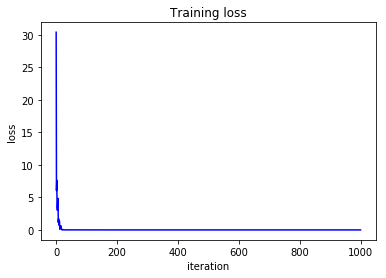

In [34]:
history = []

for i in range(epochs):
    for x, y_true in loader(X, Y, batch_size):
        # forward -- считаем все значения до функции потерь
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
        
        #print(y_pred, y_true)
        #print('SUM OF SQUARES:', np.mean(np.power(y_pred-y_true, 2)))
    
        # backward -- считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        
        # обновляем веса
        SGD(model.parameters(),
            model.grad_parameters(),
            learning_rate)
        
        #print(model.layers[0].W[0][0])
        print(loss)
        
        history.append(loss)

    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

# Логистическая регрессия

Этот пример нужнен для теситрования классификации (`CrossEntropy` и `SoftMax`).

Возьмем в качестве датасета точки из двух гауссиан на плоскости.

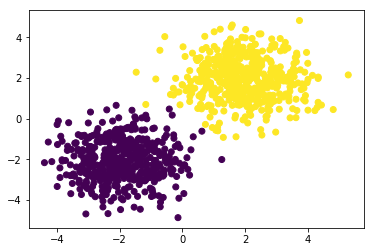

In [23]:
n = 500

X1 = np.random.randn(n, 2) + np.array([2, 2])
X2 = np.random.randn(n, 2) + np.array([-2, -2])
X = np.vstack([X1, X2])

Y = np.concatenate([np.ones(n), np.zeros(n)])[:, None]
Y = np.hstack([y, 1-y])

plt.scatter(X[:,0], X[:,1], c=Y[:,0])
plt.show()

Обратите внимание на `y`. Он в формате one-hot: у каждого вектора все нули, кроме одной единицы.

Выходные данные в таком формате упростят написание `CrossEntropy`.

### Модель

Логистическая регрессия — это тоже как бы маленькая нейронка: линейный слой, софтмакс, и максимизируем правдоподобие.

In [20]:
model = Sequential(
    Linear(2, 2),
    SoftMax()
)

criterion = CrossEntropy()

### Обучение

In [22]:
epochs = 10
batch_size = 16
learning_rate = 1e-2

In [ ]:
history = []

for i in range(epochs):
    for x, y_true in loader(X, Y, batch_size):
        # forward -- считаем все значения до функции потерь
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y)
    
        # backward -- считаем все градиенты в обратном порядке
        grad = criterion.backward(predictions, y_true)
        net.backward(x, grad)
        
        # обновляем веса
        SGD(model.parameters(),
            model.grad_parameters(),
            learning_rate)
        
        history.append(loss)

    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(loss_history, 'b')
plt.show()

Мы тут пропустили много важных деталей: валидация, подсчет точности (кроссэнтропия не очень инфорамативна), регуляризация. Вам всё это нужно будет реализовать потом самим.

# Теперь сами

In [ ]:
import os
from sklearn.datasets import fetch_mldata
# эти библиотеки нужны только для того, чтобы скачать MNISt

if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_mldata("mnist-original")
    # очень важно его отнормировать -- см. Linear в hw_framework
    X = mnist.data / 255.0
    y = mnist.target
    np.savez('mnist.npz', X=X, y=y)

Переведите лейблы в one-hot.

In [ ]:
# ...

Разделите датасет на train и validation.

In [ ]:
# ...

Теперь напишите модель и train loop. Можете начать с адаптации предыдущего примера.

Дальше начинается творческая часть и настоящий Deep Learning:
* Поиграйтесь с архитектурами
* Поиграйтесь с learning rate и batch_size
* Сделайте learning rate decay
* Сделайте data augmentation

In [ ]:
# ...

In [ ]:
# ...